In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
import pandas as pd
import numpy as np
import json
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Images

The dataset contains satellite images taken from Google Earth of tank-containing industrial areas around the world. Images are annotated with bounding box information for floating head tanks in the image. There are 100 such images present. Since the images are big, each image is divided into smaller images. 

The large_images directory contains the raw 4800x4800 images and the image_patches directory contains 512x512 patches generated from the large image. 
Each large image is split into 100 512x512 patches with an overlap of 37 pixels between patches on both axes. Image patches are named following an id_row_column.jpg format.

There are total 10,000 images_patches which we will use to split in train and test.



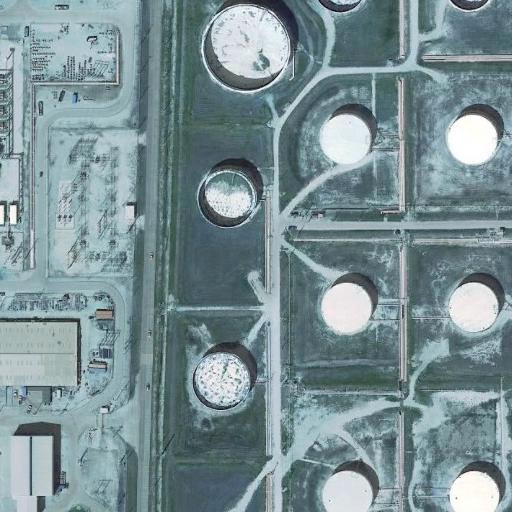

In [4]:
img = cv2.imread(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile/01_4_9.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2_imshow(img)

As we can see, there are both Floating Tank and Fixed tanks in the image. Taking a closer look at the images, we can see rhat the Floating head tanks cast an interior shadow while fixed head tanks doesn't.

# Labels.json file 

In [5]:
dir_path = '/content/gdrive/My Drive/Oil Tanks/'

f = open(dir_path + 'labels.json')
labels = json.load(f)

labels.json contains labels for all images. Labels are stored as a list of dictionaries, one for each image. Images that do not contain any floating head tanks are given a label of 'skip'. Bounding box labels are in the format of (x, y) coordinate pairs of the four corners of the bounding box.

We will take a look at some of the labels:

In [ ]:
labels[0:5]

[{'id': 0, 'file_name': '01_0_0.jpg', 'label': 'Skip'},
 {'id': 1, 'file_name': '01_0_1.jpg', 'label': 'Skip'},
 {'id': 2, 'file_name': '01_0_2.jpg', 'label': 'Skip'},
 {'id': 3, 'file_name': '01_0_3.jpg', 'label': 'Skip'},
 {'id': 4,
  'file_name': '01_0_4.jpg',
  'label': {'Tank': [{'geometry': [{'x': 438, 'y': 254},
      {'x': 438, 'y': 271},
      {'x': 455, 'y': 271},
      {'x': 455, 'y': 254}]},
    {'geometry': [{'x': 388, 'y': 259},
      {'x': 388, 'y': 279},
      {'x': 408, 'y': 279},
      {'x': 408, 'y': 259}]}]}}]

In [ ]:
len(labels)

10000

There are total 10,000 images and for each image we have corresponding entry in the Labels file, hence it is of length 10000. When we print the data for top 5 images we can see that the first 4 images do not contain any floating head tanks hence the label is a 'string' datatype with value of 'Skip'. The 5th image has the id: 4 as it is 0 indexed and the corresponding file name: 01_0_4.jpg. 

The label section for this image contains the objects in the image. When there are objects present it is stored as a dictionary with keys as the Object name and it's corresponding value would contain details of all images for that corresponding class.

We will take a look at an example, we will take a look at the image with id:39 and breakdown it's details.

In [ ]:
labels[39]

{'id': 39,
 'file_name': '01_3_9.jpg',
 'label': {'Tank': [{'geometry': [{'x': 30, 'y': 388},
     {'x': 30, 'y': 401},
     {'x': 44, 'y': 401},
     {'x': 44, 'y': 388}]},
   {'geometry': [{'x': 445, 'y': 277},
     {'x': 445, 'y': 329},
     {'x': 498, 'y': 329},
     {'x': 498, 'y': 277}]},
   {'geometry': [{'x': 355, 'y': 249},
     {'x': 355, 'y': 271},
     {'x': 379, 'y': 271},
     {'x': 379, 'y': 249}]}],
  'Floating Head Tank': [{'geometry': [{'x': 224, 'y': 260},
     {'x': 224, 'y': 349},
     {'x': 315, 'y': 349},
     {'x': 315, 'y': 260}]},
   {'geometry': [{'x': 313, 'y': 432},
     {'x': 313, 'y': 489},
     {'x': 368, 'y': 489},
     {'x': 368, 'y': 432}]},
   {'geometry': [{'x': 444, 'y': 434},
     {'x': 444, 'y': 487},
     {'x': 496, 'y': 487},
     {'x': 496, 'y': 434}]},
   {'geometry': [{'x': 201, 'y': 478},
     {'x': 201, 'y': 512},
     {'x': 291, 'y': 512},
     {'x': 291, 'y': 478}]}],
  'Tank Cluster': [{'geometry': [{'x': 418, 'y': 244},
     {'x': 418,

In [ ]:
print("id of image: ", labels[39]['id'])
print("Name of image: ", labels[39]['file_name'])
print("Classes present in image: ", list(labels[39]['label'].keys()))
print("Images present under 'Tank' label: ", len(labels[39]['label']['Tank']))
print("Images present under 'Floating Head Tank' label: ", len(labels[39]['label']['Floating Head Tank']))
print("Images present under 'Tank Cluster' label: ", len(labels[39]['label']['Tank Cluster']))

id of image:  39
Name of image:  01_3_9.jpg
Classes present in image:  ['Tank', 'Floating Head Tank', 'Tank Cluster']
Images present under 'Tank' label:  3
Images present under 'Floating Head Tank' label:  4
Images present under 'Tank Cluster' label:  1


In [ ]:
print("Format of Coordinates present under each class: ", labels[39]['label']['Tank Cluster'][0]['geometry'])

Format of Coordinates present under each class:  [{'x': 418, 'y': 244}, {'x': 418, 'y': 263}, {'x': 454, 'y': 263}, {'x': 454, 'y': 244}]


We are given 4 coordinates of the image. On comparing it to the other coordinates I noticed that the images are not in a fixed format i.e. from the coordinates we cannot say that the first coordinate is of the bottom left or top left. It could depend on how the images were labelled.

# Labels_Coco.json file

In [ ]:
f = open(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/labels_coco.json')
labels_coco = json.load(f)

In [ ]:
print("Type of Labels_Coco file: ", type(labels_coco))
print("Elements in Labels_Coco: ", len(labels_coco))
print("Keys in File: ", list(labels_coco.keys()))

Type of Labels_Coco file:  <class 'dict'>
Elements in Labels_Coco:  3
Keys in File:  ['categories', 'annotations', 'images']


We will take a look at each element 1 by 1. Let's start with Categories field.

In [ ]:
print("First Element of Labels_coco file", labels_coco['categories'])

First Element of Labels_coco file [{'id': 1, 'name': 'Floating Head Tank'}]


This tells us there in the labels_coco file, entries are present for only 1 category which is Floating Head Tank, next we will take a look at the next Field.

In [ ]:
print(type(labels_coco['annotations']), len(labels_coco['annotations']))
labels_coco['annotations'][:5]

<class 'list'> 5820


[{'image_id': 28, 'category_id': 1, 'bbox': [275, 414, 59, 57]},
 {'image_id': 30, 'category_id': 1, 'bbox': [416, 147, 21, 19]},
 {'image_id': 39, 'category_id': 1, 'bbox': [224, 260, 91, 89]},
 {'image_id': 39, 'category_id': 1, 'bbox': [313, 432, 55, 57]},
 {'image_id': 39, 'category_id': 1, 'bbox': [444, 434, 52, 53]}]

Annoations contain list of all the bounding boxes for Floating Head Tank, if we notice the number of bounding boxes matches number of Floating Head Tanks we got from labels.json file.

# Counting Instances

As we saw in labels_Coco dataset, there are 5820 records for Floating Head Tanks. We will take a look at labels data to understand how many instances of each class are there.

In [11]:
#getting number of classes and annotations in each class

classes = {}

for i in labels:
  #print(i['id'])
  if type(i['label']) != dict:
    if classes.get(i['label'], -1) == -1: classes[i['label']] = 1
    else: classes[i['label']] += 1
  else:
    
    for cls in i['label'].keys():
      if classes.get(cls, -1) == -1: classes[cls]= len(i['label'][cls])
      else: classes[cls] += len(i['label'][cls])

print(classes)

{'Skip': 8171, 'Tank': 3042, 'Tank Cluster': 189, 'Floating Head Tank': 5820}


In [13]:
print("Number of Bounding boxes for Floating Head Tank: ", classes['Floating Head Tank'])
print("Number of Bounding boxes for Tank: ", classes['Tank'])
print("Number of Bounding boxes for Tank Cluster: ", classes['Tank Cluster'])

Number of Bounding boxes for Floating Head Tank:  5820
Number of Bounding boxes for Tank:  3042
Number of Bounding boxes for Tank Cluster:  189


Number of Floating Head Tanks matches wih the records in labels_coco file.

([<matplotlib.axis.XTick at 0x7f49fbb1d6a0>,
 [Text(0, 0, 'Skip'),
  Text(0, 0, 'Tank'),
  Text(0, 0, 'Tank Cluster'),
  Text(0, 0, 'Floating Head Tank')])

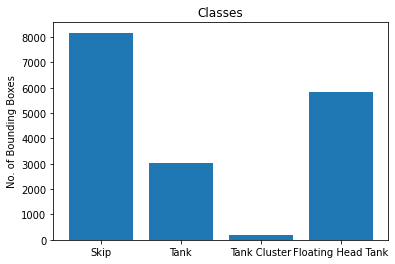

In [27]:
import matplotlib.pyplot as plt

plt.bar(range(len(classes.keys())), classes.values())

plt.title("Classes")
plt.ylabel("No. of Bounding Boxes")
plt.xticks(range(len(classes.keys())), classes.keys())


There are 8171 images out of 10000 images which do not have any object. So we can say that 81.7% images do not contain and objects. 
In the other 18.3% images, that is 1829 images there are 5820 Floating Head Tank,  3042 Fixed Tanks, 189 Tank Clusters.

Next we will take a look at out of these 1829 images, how many objects each image has.

In [31]:
object_count_dict = {}

for i in labels:
  
  object_count = 0
  if i['label']!='Skip':    
    for j in i['label'].keys():
      object_count+= len(i['label'][j])
    if object_count != 0:
      if object_count_dict.get(object_count, -1) == -1: object_count_dict[object_count] = 1
      else: object_count_dict[object_count] += 1

In [17]:
object_count_dict_keys = list(object_count_dict.keys())
object_count_dict_keys.sort()
object_count_dict_sorted = {i: object_count_dict[i] for i in object_count_dict_keys}

<BarContainer object of 42 artists>

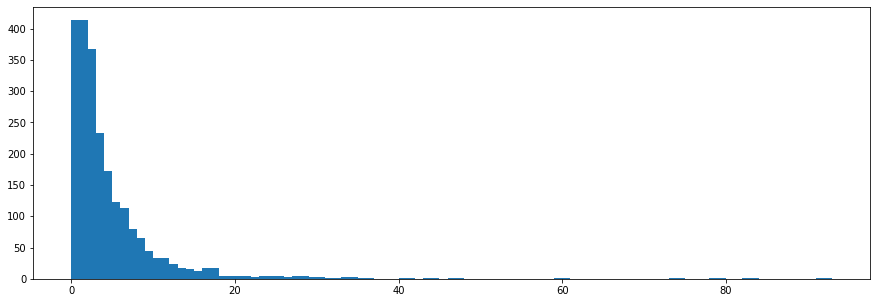

In [29]:
plt.figure(figsize=(15,5))
plt.bar(object_count_dict_sorted.keys(), object_count_dict_sorted.values(), width = 2)

As we can see there are images containing more than 80 objects as well, we will look at such an image.

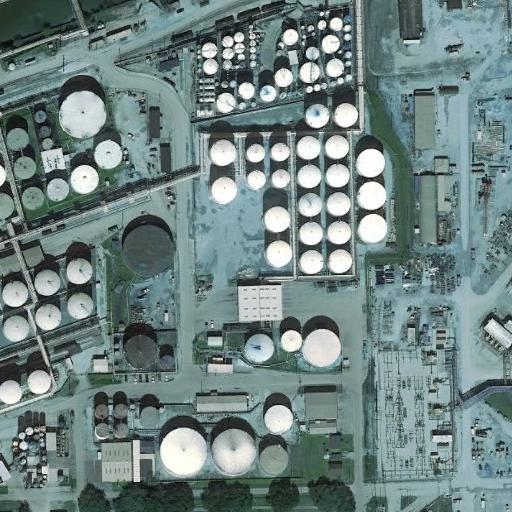

In [30]:
img = cv2.imread(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile/05_3_1.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2_imshow(img)

The image contains mostly Fixed head tanks. As in this problem we have to detect Floating Head tank, we will try to find which image has most number of floating head tanks.

In [36]:
object_count_dict = {}

for i in labels:
  
  object_count = 0
  if i['label']!='Skip':    
    for j in i['label'].keys():
      if j == "Floating Head Tank":
        object_count+= len(i['label'][j])
    if object_count != 0:
      if object_count_dict.get(object_count, -1) == -1: object_count_dict[object_count] = 1
      else: object_count_dict[object_count] += 1

object_count_dict_keys = list(object_count_dict.keys())
object_count_dict_keys.sort()
object_count_dict_sorted = {i: object_count_dict[i] for i in object_count_dict_keys}

<BarContainer object of 23 artists>

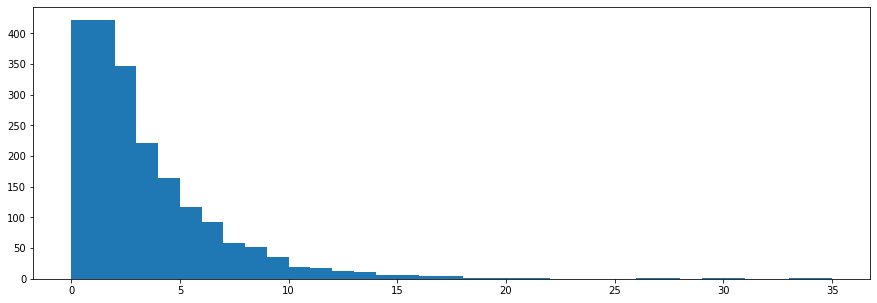

In [34]:
plt.figure(figsize=(15,5))
plt.bar(object_count_dict_sorted.keys(), object_count_dict_sorted.values(), width = 2)

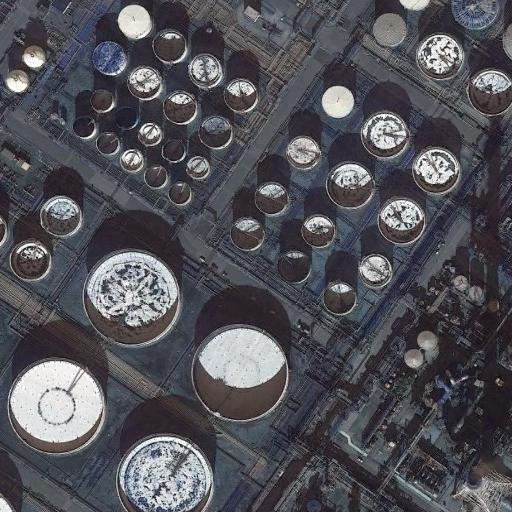

In [37]:
img = cv2.imread(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile/78_8_5.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2_imshow(img)

# Conversion of Annotation to Yolo format

In [ ]:
all_files = []
classes_dict = {'Floating Head Tank': 0, 'Tank':1, 'Tank Cluster':2}

for i in labels:
  
  file_name = i['file_name']
  file_to_be_saved = r"/content/gdrive/My Drive/Oil Tanks/Darknet/data/all labels/" + file_name.split(".")[0] + '.txt'
  
  all_files.append("data/myfile/" + file_name)
  f = open(file_to_be_saved,'w')

  if type(i['label']) != dict:
    f.close()
  else:
    items_written=0
    for cls in i['label'].keys():
      class_int = classes_dict[cls]

      for geometry in i['label'][cls]:
        
        x_s, y_s = [], []
        for jj in range(4):
          x_s.append(geometry['geometry'][jj]['x'])
          y_s.append(geometry['geometry'][jj]['y'])
        x_min, x_max = min(x_s), max(x_s)
        y_min, y_max = min(y_s), max(y_s)
        w = x_max - x_min
        h = y_max - y_min
        x = x_min + w/2
        y = y_min + h/2

        if items_written !=0: f.write('\n')

        f.write(" ".join([str(class_int),str(x/512),str(y/512), str(w/512), str(h/512)]))
        items_written += 1

In the above code, I am using all 4 coordinates to identify the x_min, y_min, x_max, y_max which would give us the coordinates of Left bottom and right top corners of the bounding box. Using this information we are calculating the width and height of the box which is used to get the center coordinates of the box. I have also converted the classes to the integer values:

Floating Head Tank: 0, 

Tank:1, 

Tank Cluster:2

The format accepted by the Yolo algorithm is "Class x y w h" where class is an integer value denoted to each of the classes, x and y are the coordinates of the center of the bounding box and w & h are width and height of the bounding boxes.

We will now look at a converted value and plot the boundign box for it.


1.0 0.673828125 0.2705078125 0.1015625 0.103515625
1.0 0.9228515625 0.2724609375 0.107421875 0.103515625
1.0 0.6748046875 0.6005859375 0.103515625 0.099609375
1.0 0.92578125 0.5986328125 0.09765625 0.099609375
1.0 0.6787109375 0.9580078125 0.103515625 0.080078125
1.0 0.927734375 0.95703125 0.09765625 0.08203125
0.0 0.478515625 0.09375 0.18359375 0.17578125
0.0 0.4423828125 0.3857421875 0.119140625 0.119140625
0.0 0.431640625 0.7431640625 0.1171875 0.115234375
0.0 0.6650390625 0.013671875 0.091796875 0.0234375
0.0 0.916015625 0.013671875 0.0859375 0.0234375


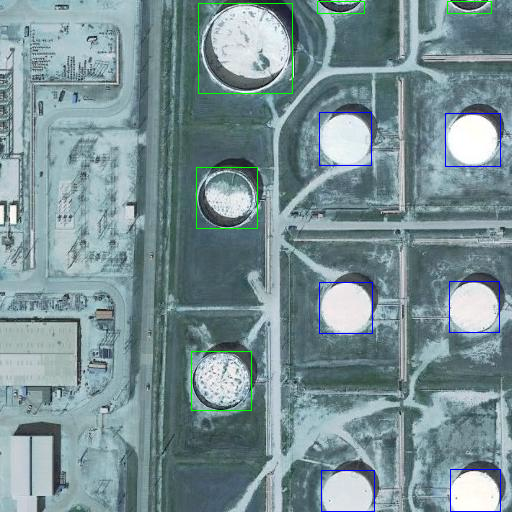

In [46]:
#reading the file

with open(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile/01_4_9.txt', 'r') as f:
  lines = f.readlines()

img = cv2.imread(r'/content/gdrive/My Drive/Oil Tanks/Darknet/data/myfile/01_4_9.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

bb_colour = {0: (0, 255, 0), 1:(255, 0, 0), 2: (0, 0, 255)}

for i in lines:
  
  c, x, y, w, h = float(i.split(" ")[0]), float(i.split(" ")[1]), float(i.split(" ")[2]), float(i.split(" ")[3]), float(i.split(" ")[4])
  print(c, x, y, w, h)
  bb_TL, bb_br = (int((x-w/2)*512), int((y-h/2)*512)), (int((x+w/2)*512), int((y+h/2)*512))
  
  # read the color image and covert to RGB
  img = cv2.rectangle(img, bb_TL, bb_br, bb_colour[c], 1)

cv2_imshow(img)